In [1]:
# Import Necessary Libraries
import warnings  # To suppress warnings
import numpy as np  # For numerical operations
import pandas as pd  # For data manipulation and analysis
import seaborn as sns  # For advanced visualizations
import matplotlib.pyplot as plt  # For plotting basic visualizations
from sklearn.preprocessing import StandardScaler
import os  # For file handling
# Suppress warnings
warnings.filterwarnings("ignore")
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA




In [ ]:
df = pd.read_csv("inventory_data.csv")


In [3]:
df.head()

,Date,Item_ID,Item_Type,Item_Name,Current_Stock,Min_Required,Max_Capacity,Unit_Cost,Avg_Usage_Per_Day,Restock_Lead_Time,Vendor_ID
0,2024-10-01,105,Consumable,Ventilator,1542,264,1018,4467.55,108,17,V001
1,2024-10-02,100,Equipment,Ventilator,2487,656,3556,5832.29,55,12,V001
2,2024-10-03,103,Equipment,Surgical Mask,2371,384,5562,16062.98,470,6,V001
3,2024-10-04,103,Consumable,Surgical Mask,2038,438,1131,744.10,207,15,V002
4,2024-10-05,107,Equipment,IV Drip,2410,338,1013,15426.53,158,12,V003


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               500 non-null    object 
 1   Item_ID            500 non-null    int64  
 2   Item_Type          500 non-null    object 
 3   Item_Name          500 non-null    object 
 4   Current_Stock      500 non-null    int64  
 5   Min_Required       500 non-null    int64  
 6   Max_Capacity       500 non-null    int64  
 7   Unit_Cost          500 non-null    float64
 8   Avg_Usage_Per_Day  500 non-null    int64  
 9   Restock_Lead_Time  500 non-null    int64  
 10  Vendor_ID          500 non-null    object 
dtypes: float64(1), int64(6), object(4)
memory usage: 43.1+ KB


In [5]:
# Check for Duplicates and Drop Duplicates.
duplicate_count = df.duplicated().sum()
print("\nNumber of Duplicate Rows:", duplicate_count)
if duplicate_count > 0:
    df.drop_duplicates(inplace=True)
    print("Duplicates removed.")
else:
    print("No duplicate rows found.")


Number of Duplicate Rows: 0
No duplicate rows found.


In [6]:
# view statistical measures for numerical columns

df.describe().T

,count,mean,std,min,25%,50%,75%,max
Item_ID,500.0,104.50800,2.865372,100.00,102.0000,104.00,107.000,109.00
Current_Stock,500.0,2458.64400,1390.078133,69.00,1307.7500,2411.50,3719.000,4976.00
Min_Required,500.0,485.98200,292.054772,10.00,215.7500,496.50,734.250,995.00
Max_Capacity,500.0,3288.83400,1602.646278,500.00,1847.7500,3311.00,4696.000,5992.00
Unit_Cost,500.0,10277.32598,5728.684410,4.23,5422.4625,10129.96,15206.315,19984.16
Avg_Usage_Per_Day,500.0,261.80400,143.983318,2.00,150.5000,257.00,392.000,499.00
Restock_Lead_Time,500.0,15.11600,8.610856,1.00,7.0000,16.00,23.000,29.00


In [7]:
# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'])



In [8]:
df.head()

,Date,Item_ID,Item_Type,Item_Name,Current_Stock,Min_Required,Max_Capacity,Unit_Cost,Avg_Usage_Per_Day,Restock_Lead_Time,Vendor_ID
0,2024-10-01,105,Consumable,Ventilator,1542,264,1018,4467.55,108,17,V001
1,2024-10-02,100,Equipment,Ventilator,2487,656,3556,5832.29,55,12,V001
2,2024-10-03,103,Equipment,Surgical Mask,2371,384,5562,16062.98,470,6,V001
3,2024-10-04,103,Consumable,Surgical Mask,2038,438,1131,744.10,207,15,V002
4,2024-10-05,107,Equipment,IV Drip,2410,338,1013,15426.53,158,12,V003


this is a small generated dataset, contains alot of logical errors which makes it hard to fully rely on it. But on the other hand, it's content represent a very important use case and after a lot of search, I couldn't find any replicant. So, I decided to work on this one. at least I'll walk through the full methedology which I can apply later on any better dataset.

My first target here is to use these data to predict shortage in stock levels. So, the resulted model can be integrated with other systems which feed it automatically with it's features and get prediction.

to apply this, I'll deal with this dataset as unsupervised data and my first step is labeling it with shortage classes using clustering.

In [9]:
# Select Relevant Features for Clustering

features = ["Current_Stock", "Avg_Usage_Per_Day", "Restock_Lead_Time", "Min_Required"]
X = df[features].copy()

In [10]:
# Since K-Means is distance-based, we need to scale the data.

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

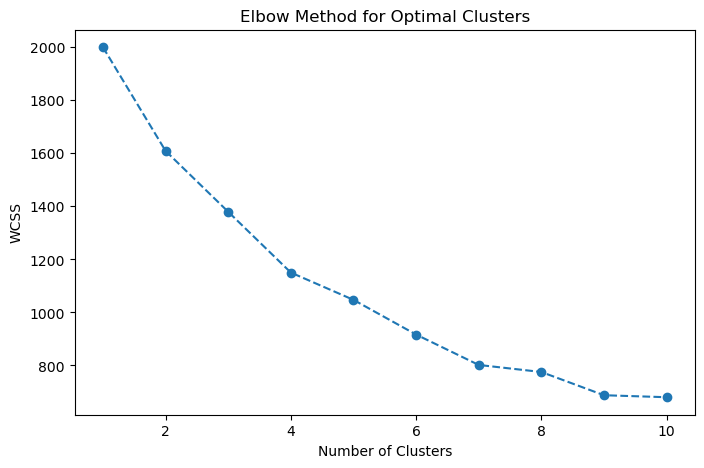

In [11]:
# We use the Elbow Method to determine the best k:

wcss = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)  # Inertia = Sum of squared distances to cluster centers

# Plot the elbow method
plt.figure(figsize=(8, 5))
plt.plot(k_values, wcss, marker="o", linestyle="dashed")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.title("Elbow Method for Optimal Clusters")
plt.show()

Based on the Elbow Method plot, the best value of k is typically where the WCSS (within-cluster sum of squares) curve starts to flatten out, forming an "elbow."

From the plot, the elbow point appears to be at k = 4, since the decrease in WCSS slows down significantly after this point.

In [12]:
# Apply K-Means++

kmeans = KMeans(n_clusters=4, init="k-means++", random_state=42)
df["cluster"] = kmeans.fit_predict(X_scaled)

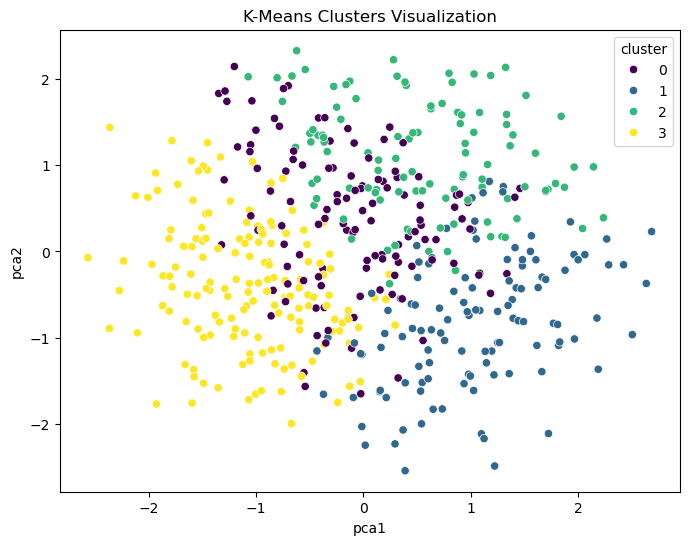

In [13]:
# Since we have multiple features, we use PCA to reduce it to 2D.

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df["pca1"] = X_pca[:, 0]
df["pca2"] = X_pca[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(x="pca1", y="pca2", hue=df["cluster"], palette="viridis", data=df)
plt.title("K-Means Clusters Visualization")
plt.show()

In [14]:
# We analyze feature statistics for each cluster.

print(df.groupby("cluster").mean(numeric_only=True))


            Item_ID  Current_Stock  Min_Required  Max_Capacity     Unit_Cost  \
cluster                                                                        
0        104.789916    2314.747899    248.445378   3376.655462  10807.359832   
1        104.425000    3055.891667    753.575000   3341.366667  10780.187500   
2        104.409524    2466.647619    715.819048   3182.152381  10119.655619   
3        104.423077    2103.602564    306.641026   3253.237179   9592.313013   

         Avg_Usage_Per_Day  Restock_Lead_Time      pca1      pca2  
cluster                                                            
0               313.588235          22.865546 -0.114308  0.351674  
1               392.716667          13.808333  1.023338 -0.800996  
2               115.847619          20.028571  0.546645  1.089456  
3               219.839744           6.903846 -1.067921 -0.385400  


In [15]:
# shortage_risk, based on comparison between current_stock and (Avg_Usage_Per_Day * Restock_Lead_Time)

shortage_risk_mapping = {
    0: 1,  # High risk
    1: 1,  # High risk
    2: 0,   # Low risk
    3: 0   # Low risk
}

df["Shortage_Risk"] = df["cluster"].map(shortage_risk_mapping)

In [16]:
# Verify Labels

print(df[["Current_Stock", "Avg_Usage_Per_Day", "Restock_Lead_Time", "Shortage_Risk"]].head())


   Current_Stock  Avg_Usage_Per_Day  Restock_Lead_Time  Shortage_Risk
0           1542                108                 17              0
1           2487                 55                 12              0
2           2371                470                  6              1
3           2038                207                 15              0
4           2410                158                 12              0


In [17]:
df.head()

,Date,Item_ID,Item_Type,Item_Name,Current_Stock,Min_Required,Max_Capacity,Unit_Cost,Avg_Usage_Per_Day,Restock_Lead_Time,Vendor_ID,cluster,pca1,pca2,Shortage_Risk
0,2024-10-01,105,Consumable,Ventilator,1542,264,1018,4467.55,108,17,V001,3,-1.034167,1.039223,0
1,2024-10-02,100,Equipment,Ventilator,2487,656,3556,5832.29,55,12,V001,2,-0.130285,0.732992,0
2,2024-10-03,103,Equipment,Surgical Mask,2371,384,5562,16062.98,470,6,V001,1,-0.372768,-1.655065,1
3,2024-10-04,103,Consumable,Surgical Mask,2038,438,1131,744.10,207,15,V002,3,-0.367293,0.339041,0
4,2024-10-05,107,Equipment,IV Drip,2410,338,1013,15426.53,158,12,V003,3,-0.732191,0.220185,0


In [18]:
# drop unnecessary or unlogical columns

df.drop(columns=['Item_ID', 'Item_Name', 'Vendor_ID', 'cluster', 'pca1', 'pca2'], inplace=True)

df.head()

,Date,Item_Type,Current_Stock,Min_Required,Max_Capacity,Unit_Cost,Avg_Usage_Per_Day,Restock_Lead_Time,Shortage_Risk
0,2024-10-01,Consumable,1542,264,1018,4467.55,108,17,0
1,2024-10-02,Equipment,2487,656,3556,5832.29,55,12,0
2,2024-10-03,Equipment,2371,384,5562,16062.98,470,6,1
3,2024-10-04,Consumable,2038,438,1131,744.10,207,15,0
4,2024-10-05,Equipment,2410,338,1013,15426.53,158,12,0


In [19]:
# Check for Datatypes
print("\nColumn Data Types:")
print(df.dtypes)


Column Data Types:
Date                 datetime64[ns]
Item_Type                    object
Current_Stock                 int64
Min_Required                  int64
Max_Capacity                  int64
Unit_Cost                   float64
Avg_Usage_Per_Day             int64
Restock_Lead_Time             int64
Shortage_Risk                 int64
dtype: object


<h1> Univariate analysis

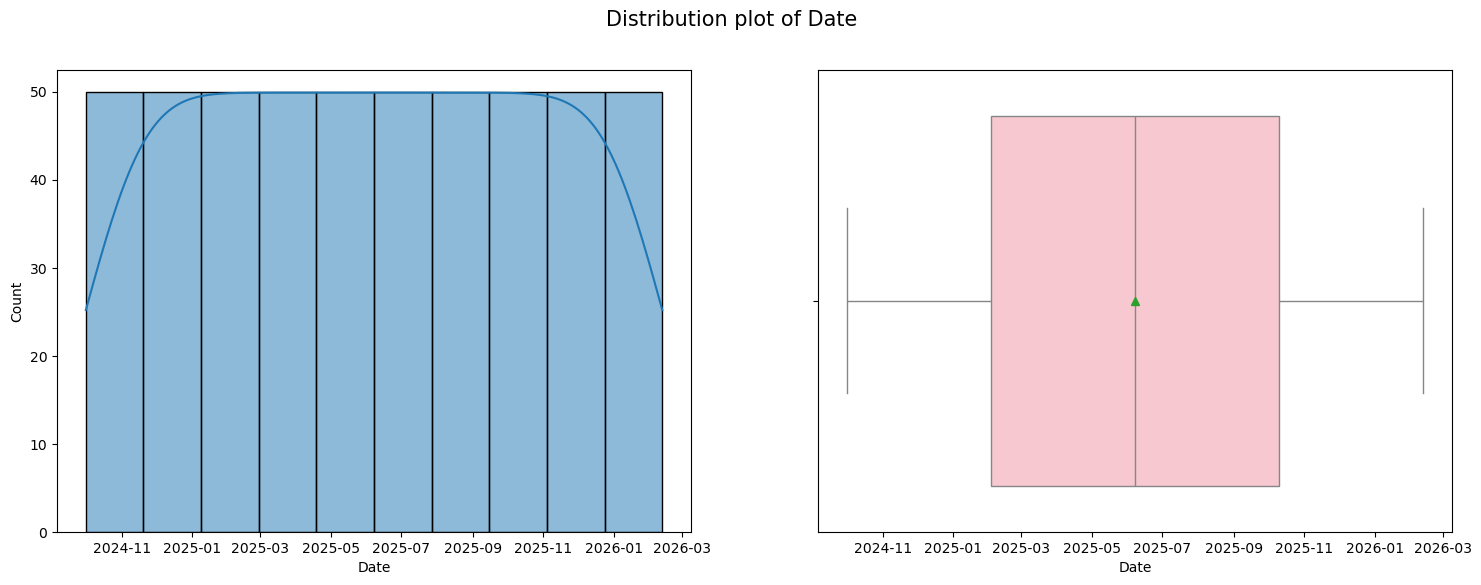

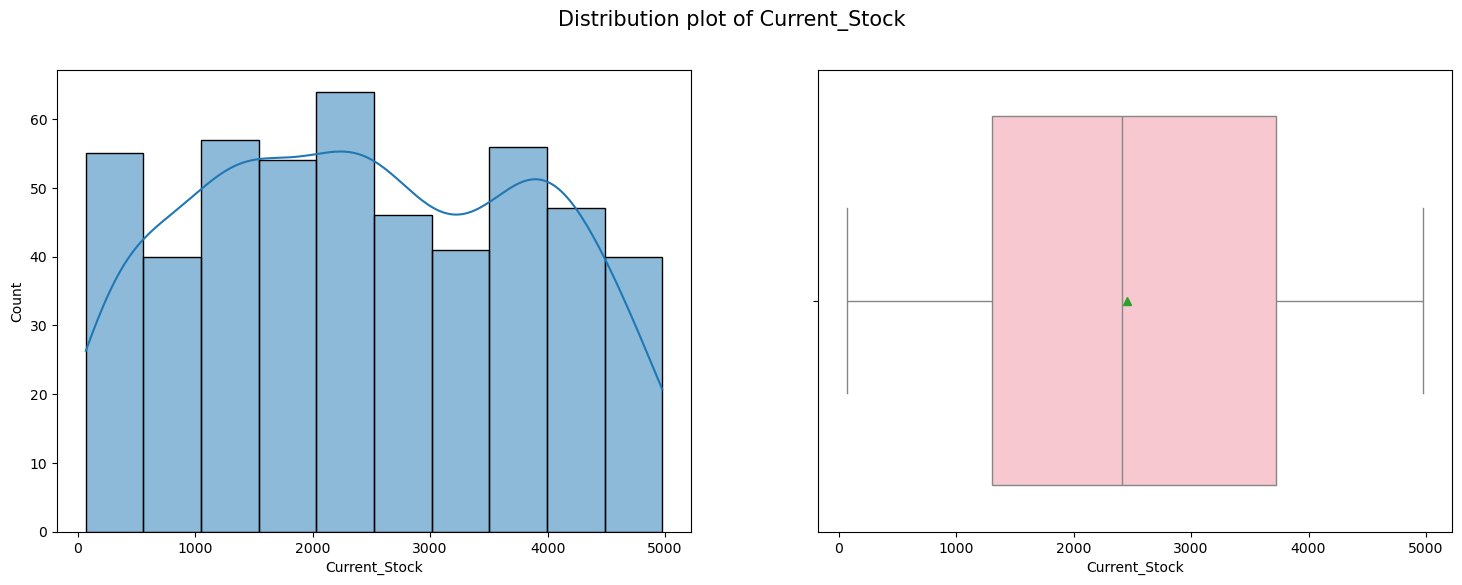

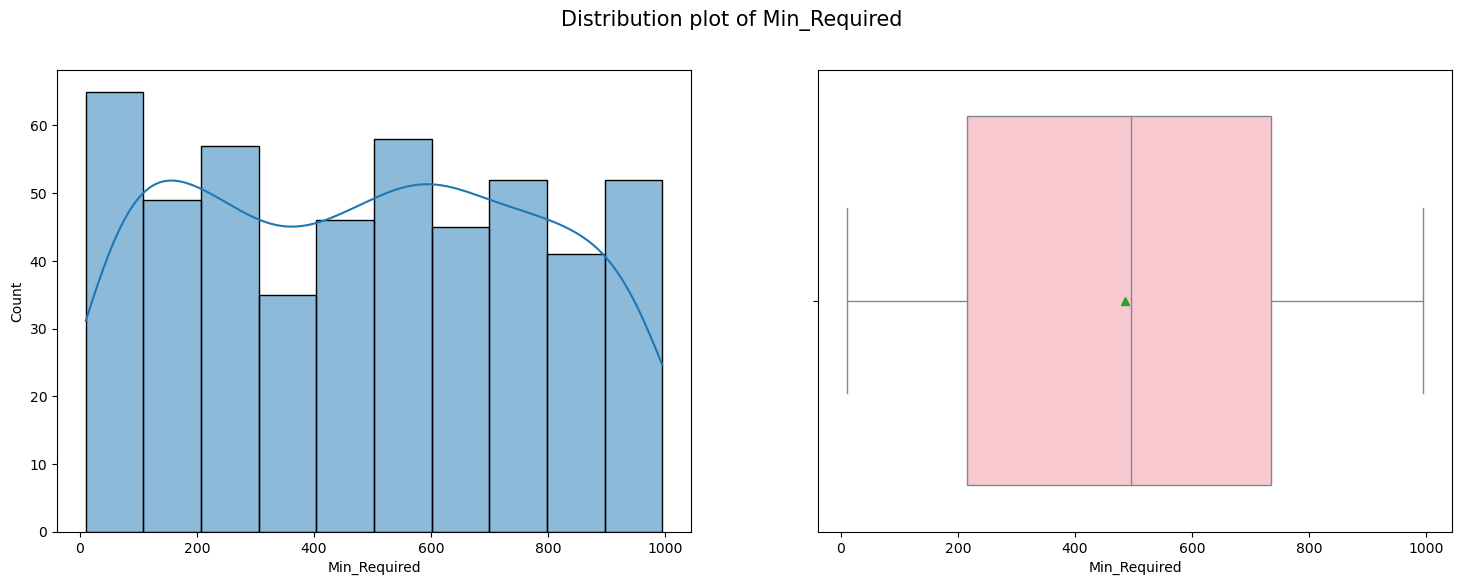

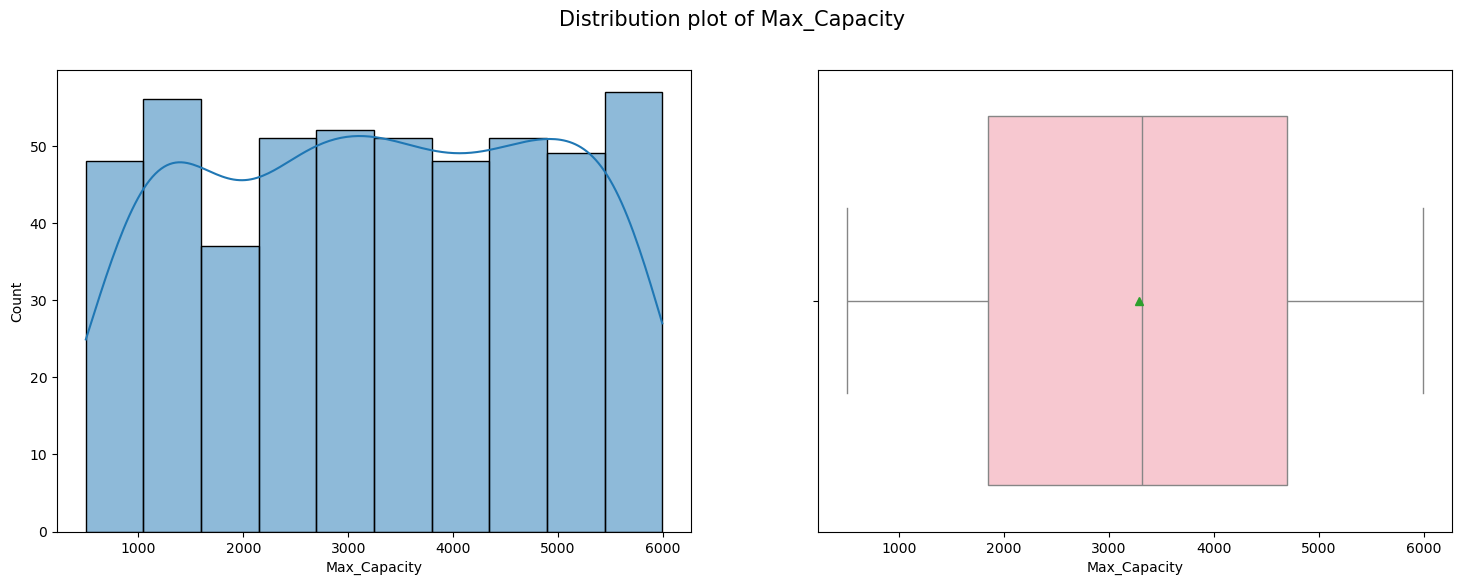

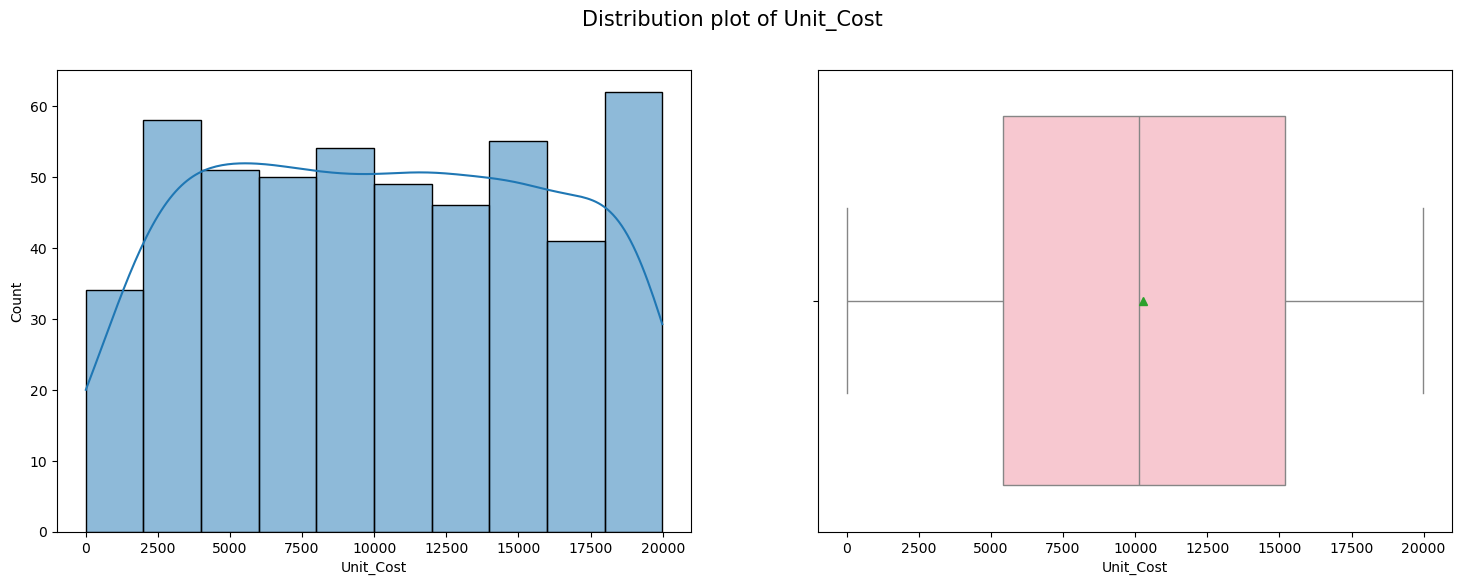

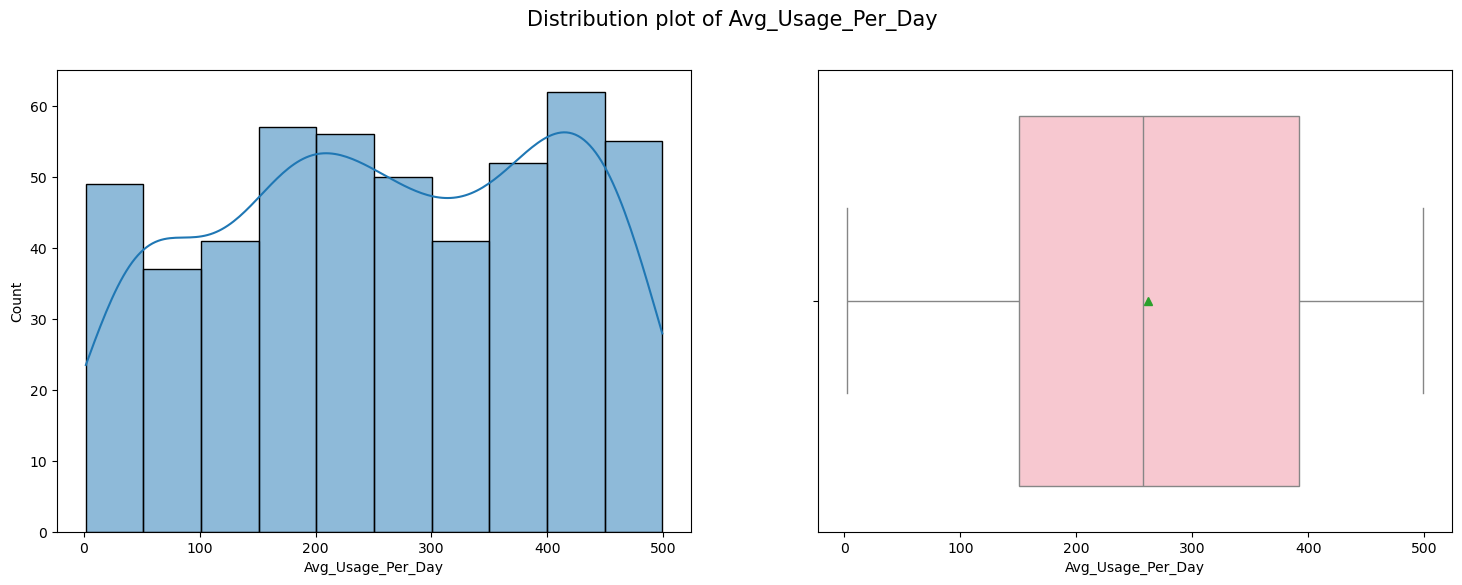

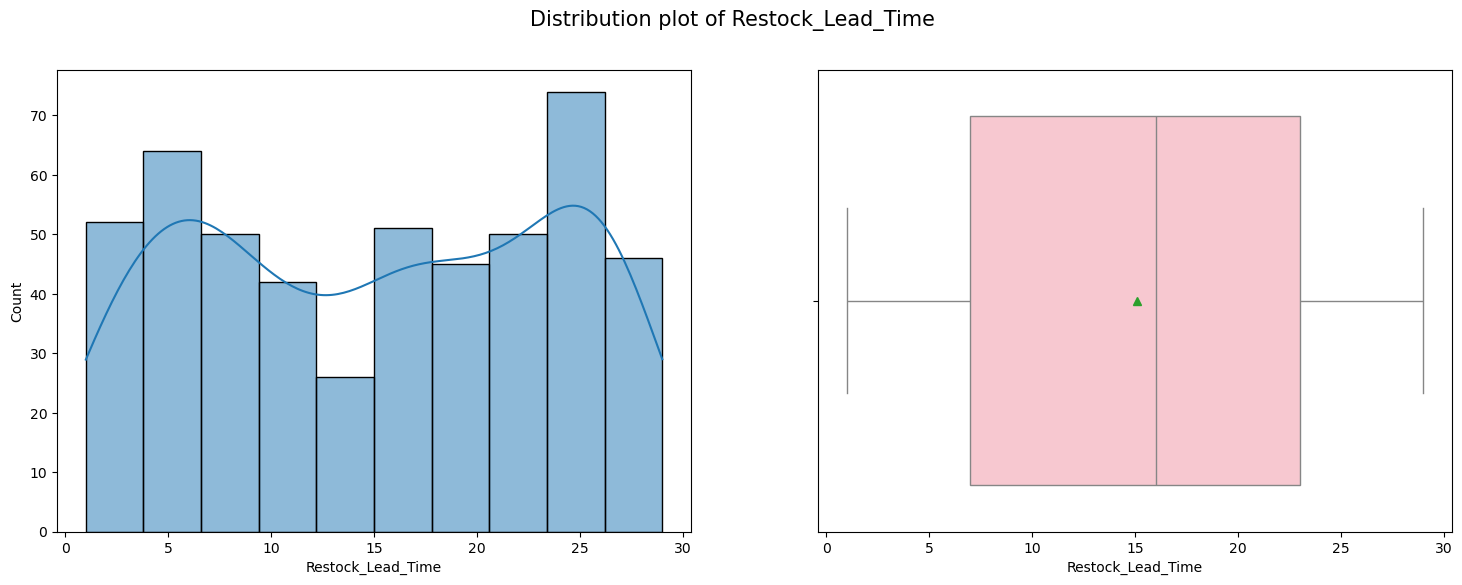

In [20]:
# numerical variables distribution and outliers visualization

for col in df.describe().columns:
    if col != 'Shortage_Risk':
        fig , axes = plt.subplots(nrows=1 , ncols=2 , figsize=(18,6))
        sns.histplot(df[col] , ax = axes[0] , kde = True)
        sns.boxplot(df[col] , ax = axes[1] , orient = 'h' , showmeans = True , color = 'pink')
        fig.suptitle("Distribution plot of " + col , fontsize = 15)
        plt.show()

The data appears roughly uniform in most columns indicating well-distribution across different values.

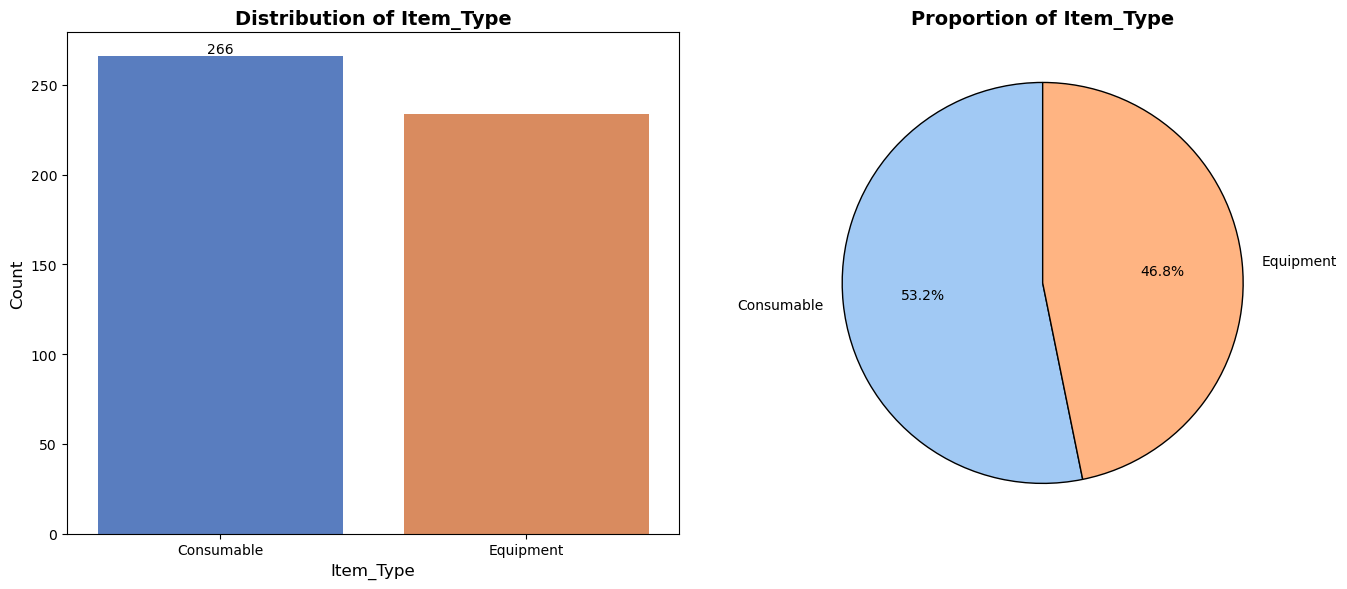

In [21]:
# categorical variable distribution

# Count occurrences of each category
type_counts = df['Item_Type'].value_counts()

# Define a color palette for better visualization
colors = sns.color_palette("pastel")

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ---- Bar Plot ----
sns.barplot(x=type_counts.index, y=type_counts.values, palette="muted", ax=axes[0])
axes[0].set_title('Distribution of Item_Type', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Item_Type', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].bar_label(axes[0].containers[0], fmt='%d', fontsize=10)  # Show count labels

# ---- Pie Chart ----
axes[1].pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', colors=colors, startangle=90, wedgeprops={'edgecolor': 'black'})
axes[1].set_title('Proportion of Item_Type', fontsize=14, fontweight='bold')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

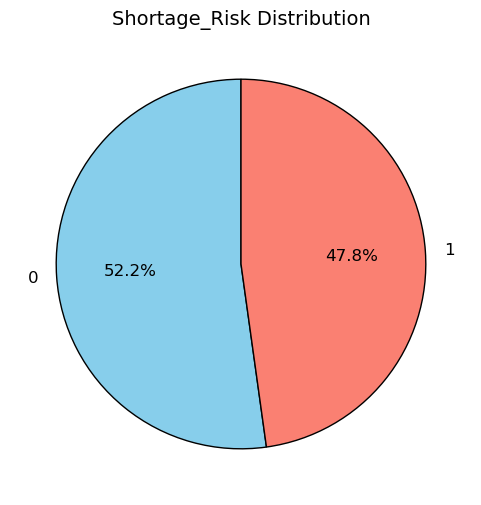

In [22]:
# target variable:-

# Count the occurrences of each category in the 'Shortage_Risk' column
Shortage_Risk_counts = df['Shortage_Risk'].value_counts()

# Define labels and sizes for the pie chart
labels = Shortage_Risk_counts.index.astype(str)  # Convert labels to strings for better visualization
sizes = Shortage_Risk_counts.values  # Extract counts

# Create a pie chart
plt.figure(figsize=(6, 6))  # Set figure size
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'salmon'], 
        wedgeprops={'edgecolor': 'black'}, textprops={'fontsize': 12})

# Add a title
plt.title('Shortage_Risk Distribution', fontsize=14)

# Display the chart
plt.show()

<h1> Bivariate Analysis

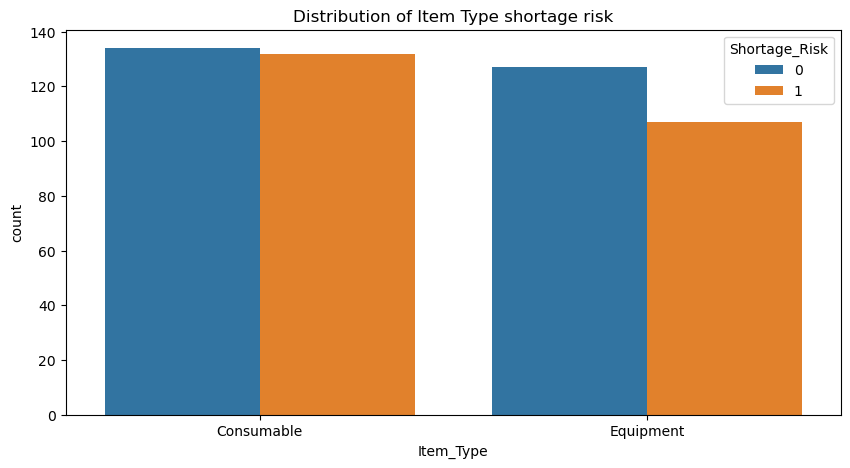

In [23]:
# categorical column with target

plt.figure(figsize=(10, 5))
sns.countplot( x = df['Item_Type'], hue = df['Shortage_Risk'])
plt.title(f"Distribution of Item Type shortage risk")  # Add title
plt.show()

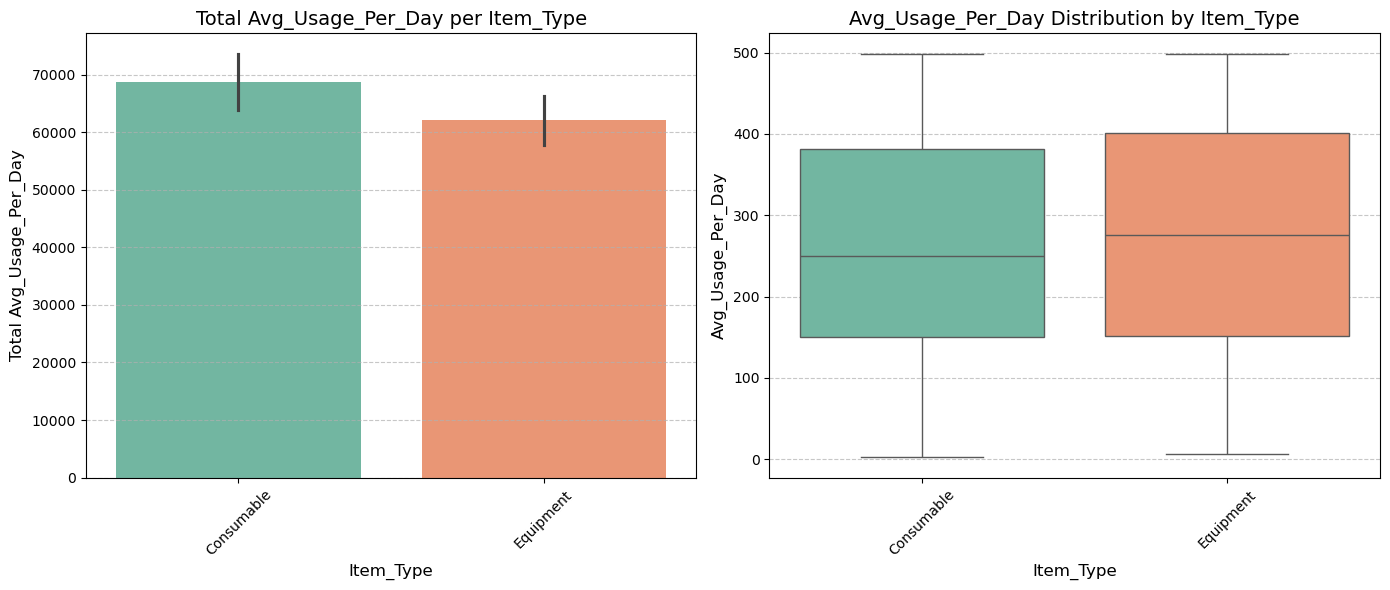

In [24]:
# how does the AVG. usage per day differ with the item type?

plt.figure(figsize=(14, 6))

# Subplot 1: Bar Chart (Average Avg_Usage_Per_Day per item type)
plt.subplot(1, 2, 1)
sns.barplot(data=df, x='Item_Type', y='Avg_Usage_Per_Day', estimator=sum, palette='Set2')
plt.title('Total Avg_Usage_Per_Day per Item_Type', fontsize=14)
plt.xlabel('Item_Type', fontsize=12)
plt.ylabel('Total Avg_Usage_Per_Day', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Subplot 2: Boxplot (Avg_Usage_Per_Day Distribution per Item_Type)
plt.subplot(1, 2, 2)
sns.boxplot(data=df, x='Item_Type', y='Avg_Usage_Per_Day', palette='Set2')
plt.title('Avg_Usage_Per_Day Distribution by Item_Type', fontsize=14)
plt.xlabel('Item_Type', fontsize=12)
plt.ylabel('Avg_Usage_Per_Day', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()
plt.show()

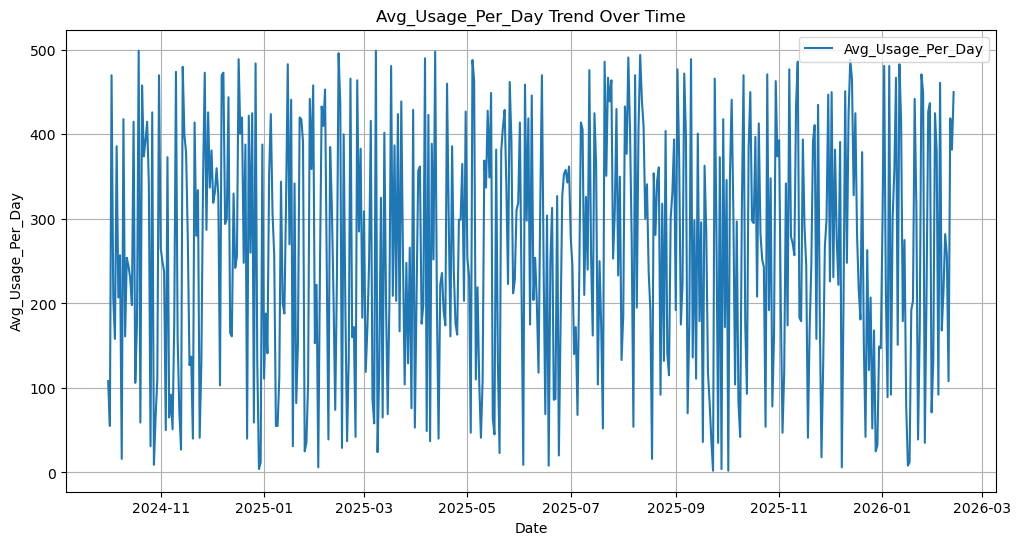

In [25]:
# Demand progress visualization
# Avg_Usage_Per_Day with the time



df.set_index('Date', inplace=True)  # Set Date as the index
df = df.sort_index()  # Ensure the dataset is sorted by date

# Plot Avg_Usage_Per_Day Over Time
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x="Date", y="Avg_Usage_Per_Day", label="Avg_Usage_Per_Day")
plt.xlabel("Date")
plt.ylabel("Avg_Usage_Per_Day")
plt.title("Avg_Usage_Per_Day Trend Over Time")
plt.legend()
plt.grid(True)
plt.show()

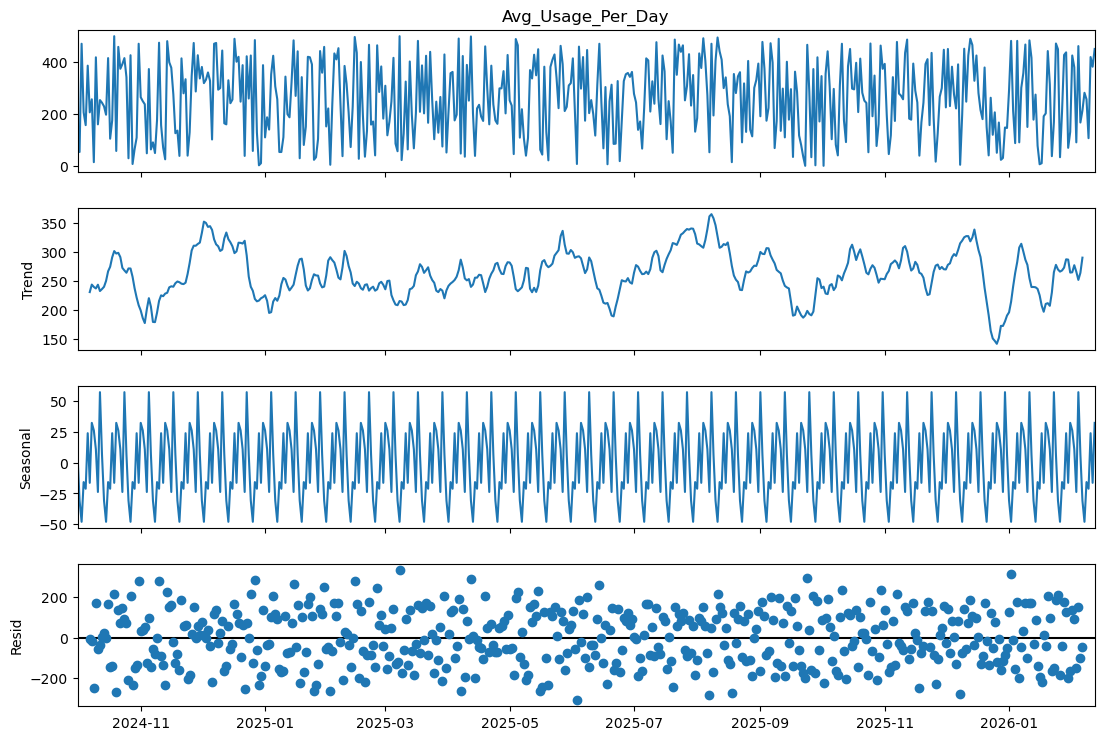

In [26]:
# Time Series Decomposition, Splits the time series into trend, seasonality, and residuals.

import statsmodels.api as sm

Avg_Usage = df['Avg_Usage_Per_Day']
decomposition = sm.tsa.seasonal_decompose(Avg_Usage, model='additive', period=12)
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.show()

Observed (First Plot - "Avg_Usage_Per_Day")

This is the original time series data of average usage per day.
The series appears to be highly fluctuating with visible ups and downs.

Trend (Second Plot)

This represents the long-term movement of the data.
it shows gradual upward and downward movements, indicating periods of increase and decrease in usage.

Seasonality (Third Plot)

This captures recurring patterns at regular intervals (e.g., daily, weekly, monthly).
The plot shows clear periodic oscillations, meaning there are repeating cycles in your data.
The fluctuations suggest the demand for medical items follows a predictable seasonal pattern.

Residual (Fourth Plot - Noise/Irregularities)

This is the remaining component after removing trend and seasonality, representing random noise.
The residuals are scattered around zero, meaning no obvious pattern remains.

In [27]:
# ADF Test for Stationarity, If p-value > 0.05, the series is non-stationary.

from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(Avg_Usage.dropna())  
print("ADF Test Statistic:", adf_test[0])
print("p-value:", adf_test[1])
print("Critical Values:", adf_test[4])

ADF Test Statistic: -22.41789147378155
p-value: 0.0
Critical Values: {'1%': -3.4435228622952065, '5%': -2.867349510566146, '10%': -2.569864247011056}


A p-value of 0  means that this time series is stationary at a very high confidence level.

I do not need to apply differencing and can directly proceed with modeling (e.g., SARIMA, Prophet, or other time series forecasting methods).

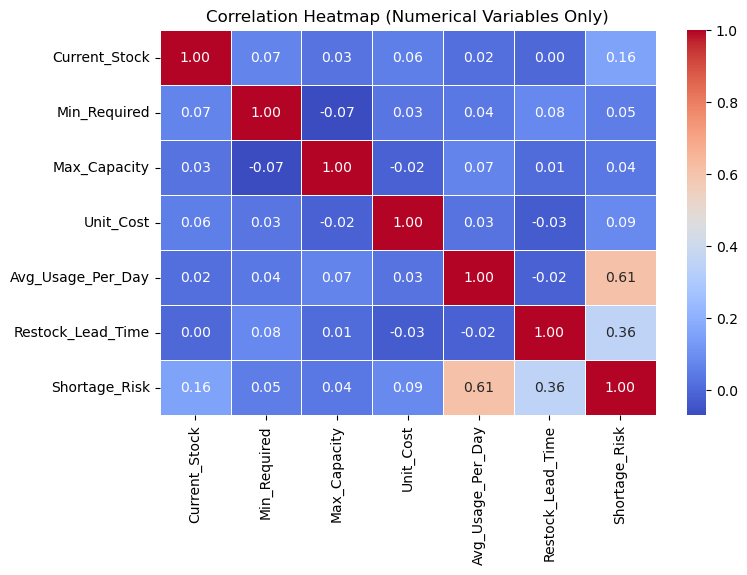

In [28]:
# correlation for all numeric variables
# Select only numerical columns
numerical_df = df.select_dtypes(include=['number'])

# Plot correlation heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(numerical_df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap (Numerical Variables Only)")
plt.show()

<h1> Feature Engineering:-

In [29]:
# new feature: "Reorder_Point" based on EOQ (Economic Order Quantity) calculation 
# Reorder Point = (AVG. usage per day × Restock Lead Time) + Safety Stock 
# current stock must be > or = this reorder point to prevent shortage

df['Reorder_Point'] = (df['Avg_Usage_Per_Day'] * df['Restock_Lead_Time']) + (df['Min_Required'] * 0.5)

In [30]:
# encoding

unique_vals = df['Item_Type'].unique()
df['Item_Type'] = df['Item_Type'].replace({unique_vals[0]: 0, unique_vals[1]: 1})

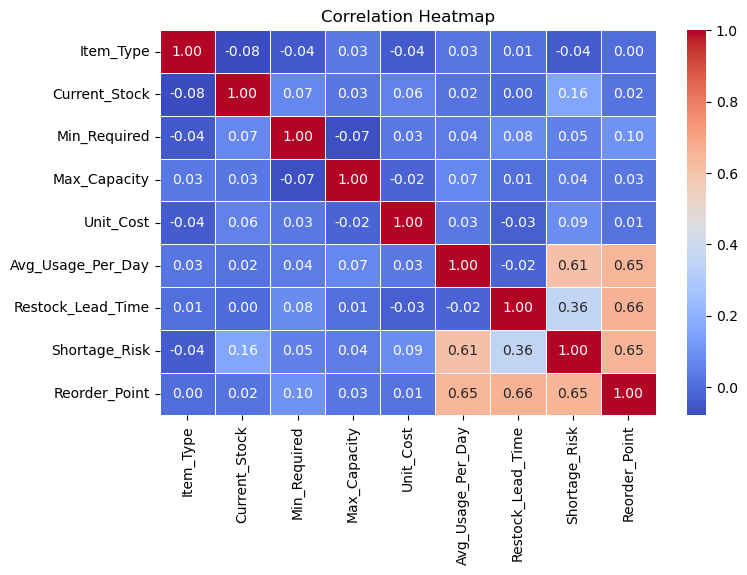

In [31]:
# Plot correlation heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

Conclusion:-

I can follow 2 different ways in modeling this dataset:-

1 - Time series modeling for Avg_Usage_Per_Day prediction using Prophet or SARIMS models.

2 - Machine learning classification model to predict shortage risk as I have a very promising correlation scores.

In [32]:
df.to_csv('inventory_clustered_EDA.csv')

Columns documentation:-

Date: record capture date, valuable for time series analysis.

Item_Type: case type for the recorded item, consumable or equipment.

Current_Stock: the current available number of this specific item in the hospital stock.

Min_Required: represents the safety stock for this item, min. number must be available all the time.

Max_Capacity: the maximum number of this item stock can handle.

Unit_Cost: price for one unit of this item.

Avg_Usage_Per_Day: average number of units needed per day.

Restock_Lead_Time: no. of days left from the record date to the next restocking process date for this item as scheduled.